<a href="https://colab.research.google.com/github/devansurf/OnePixelAttacks/blob/main/OnePixelAttack_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 3 MIT Toolbox Practice!


Install the toolbox!

In [2]:
%pip install torchattacks
%pip install rai-toolbox[mushin]

In [3]:
pip install rai-experiments

In [4]:
pip install ipywidgets

IMPORTS!!!

In [5]:
import rai_toolbox
import rai_experiments
import ipywidgets
from functools import partial
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torchvision
import torchattacks

from rai_toolbox.perturbations import gradient_ascent, AdditivePerturbation
from rai_toolbox.optim import L2ProjectedOptim

In [6]:
DATA_DIR = str(Path.home() / ".torch" / "data")
MODEL_DIR = str(Path.home() / ".torch" / "model")

In [7]:
# CPU or GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


**Define function to plot images...**

In [8]:
def plot_images(x, y, class_names, x_adv=None, y_adv=None):
    if x_adv is not None:
        fig, ax = plt.subplots(3, 10, figsize=(20, 5))
    else:
        fig, ax = plt.subplots(1, 10, figsize=(20, 5))

    for i in range(10):
        if x_adv is not None:
            ax[0, i].imshow(x[i].permute(1, 2, 0))
            ax[0, i].set_title(class_names[y[i]])
            ax[0, i].axis("off")
            ax[1, i].imshow(x_adv[i].detach().cpu().permute(1, 2, 0))
            if y_adv[i].item() != y[i].item():
                ax[1, i].set_title(class_names[y_adv[i]], color="r")
            else:
                ax[1, i].set_title(class_names[y_adv[i]], color="k")
            ax[1, i].axis("off")
            ax[2, i].imshow(
                (torch.abs(x[i] - x_adv[i].detach().cpu()) * 25)
                .clamp_(0, 1)
                .permute(1, 2, 0)
            )
            ax[2, i].axis("off")
        else:
            ax[i].imshow(x[i].permute(1, 2, 0))
            ax[i].set_title(class_names[y[i]])
            ax[i].axis("off")

# Loading the CIFAR-10 dataset
CIFAR-10 is a dataset containing 32x32 RGB images; each image depicts an object or animal belonging to one of ten classes. Here we will load images from the test set and plot a few example images from each class.

In [9]:
BATCH_SIZE = 10

# Load CIFAR10 test dataset
dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
print(f"Number of Test Samples: {len(dataset)}")

# Grab class names
class_names = dataset.classes
print(f"Classes: {class_names}")

# Instantiate a data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)

Files already downloaded and verified
Number of Test Samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


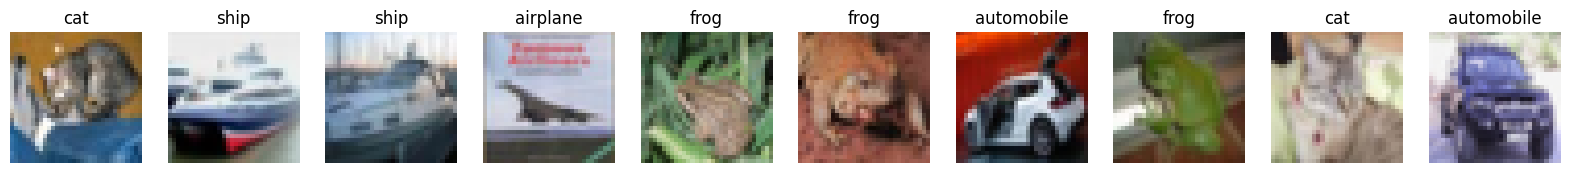

In [10]:
# Sample first batch of test data and plot
x, y = next(iter(dataloader))
plot_images(x, y, class_names)

# Loading pre-trained CIFAR-10 models
Next we will define two models: 1. model_robust is a classification model that was trained against adversarially-generated training data. 2. model_standard is a classification model that was trained against CIFAR-10 using standard (i.e., non-adversarial) data augmentation procedures.

The weights for both models are derived from Madrylab’s robustness library:

We will use two pre-trained models for these definitions: 1. mitll_cifar_l2_1_0.pt: A simplified data structure of the pre-trained model available via the mit-ll-responsible-ai/data_hosting repo. This is a ResNet-50 model trained with perturbations generated via PGD using perturbations constrained to
-ball of radius


rai_experiments.models.pretrained.load_model will automatically download and cache pre-trained weights for these models.

In [11]:
from rai_experiments.models.pretrained import load_model

In [12]:
# Load pre-trained model that was trained using a robust approach (i.e., adversarial training)
ckpt_robust = "mitll_cifar_l2_1_0.pt"
model_robust = load_model(ckpt_robust)
model_robust.eval();

# Load pre-trained model that was trained with standard approach
ckpt_standard = "mitll_cifar_nat.pt"
model_standard = load_model(ckpt_standard)
model_standard.eval();

# Obtaining adversarial perturbations for a batch of data
Now we will use the gradient_ascent function with an AdditivePerturbation model and L2ProjectedOptim optimizer from the toolbox to solve for
-norm-constrained adversarial perturbations to samples from the dataset. These are perturbations that maximize – within the given constraints – the cross-entropy classification loss measured on our model’s predictions.

We will use functools.partial to set default values for gradient_ascent, so that they can be used consistently across our two models.

In [13]:
# Define perturbation model
perturbation_model = AdditivePerturbation(x.shape)

# Define parameters for perturbation optimizer
EPS = 0.5  # L2-norm of perturbation
STEPS = 10  # number of gradient steps during perturbation optimization
FACTOR = 2.5  # factor for determining step size (learning rate)

# Function for selecting step size (learning rate) for perturbation optimizer
def get_stepsize(factor: float, steps: int, epsilon: float) -> float:
    return factor * epsilon / steps

# Define perturbation solver that we will apply to multiple models.
# Fills out all params for `gradient_ascent` except `data`, `target`, and `model`.
# Signature: solver(data: Tensor, target: Tensor, model: nn.Module)
solver = partial(
    gradient_ascent,
    perturbation_model = perturbation_model.to(device),
    optimizer=L2ProjectedOptim,
    lr=get_stepsize(FACTOR, STEPS, EPS),
    epsilon=EPS,
    steps=STEPS,
    targeted=False,
    use_best=True,
)

**We will first solve for a single batch of adversarial perturbations for our standard model. Given a batch of images, this will produce a corresponding batch of perturbed images and we will plot each image, perturbed image, and the corresponding perturbation that we solved for, which attempts to “fool” the standard model.**

/usr/local/lib/python3.10/dist-packages/rai_toolbox/optim/optimizer.py:36: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return x.storage().data_ptr() == y.storage().data_ptr()


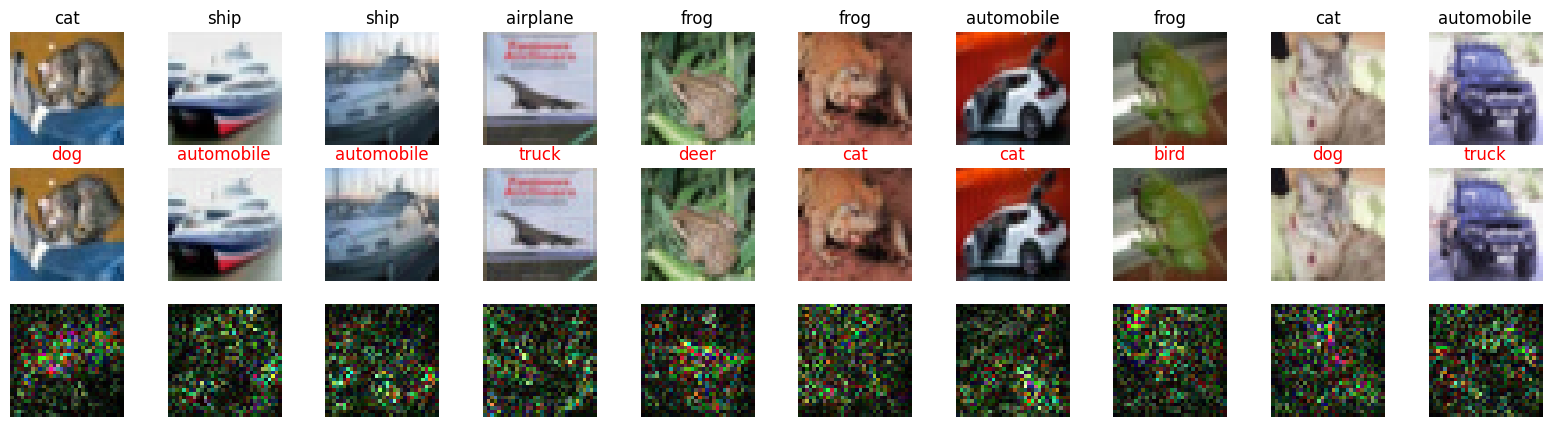

In [14]:
# Solve for adversarial perturbations to standard model and plot
x_adv, loss_adv = solver(
    data=x.to(device),
    target=y.to(device),
    model=model_standard.to(device)
)

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_standard(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
plot_images(x, y, class_names, x_adv, y_adv)

The top row is the original image with true label, the second row is the adversarially-perturbed image with the label predicted by the model, and the third row is the perturbation (multiplied by
 so it can be viewed more easily).

Now we now use the same batch of data to produce adversarial examples for our robust model.

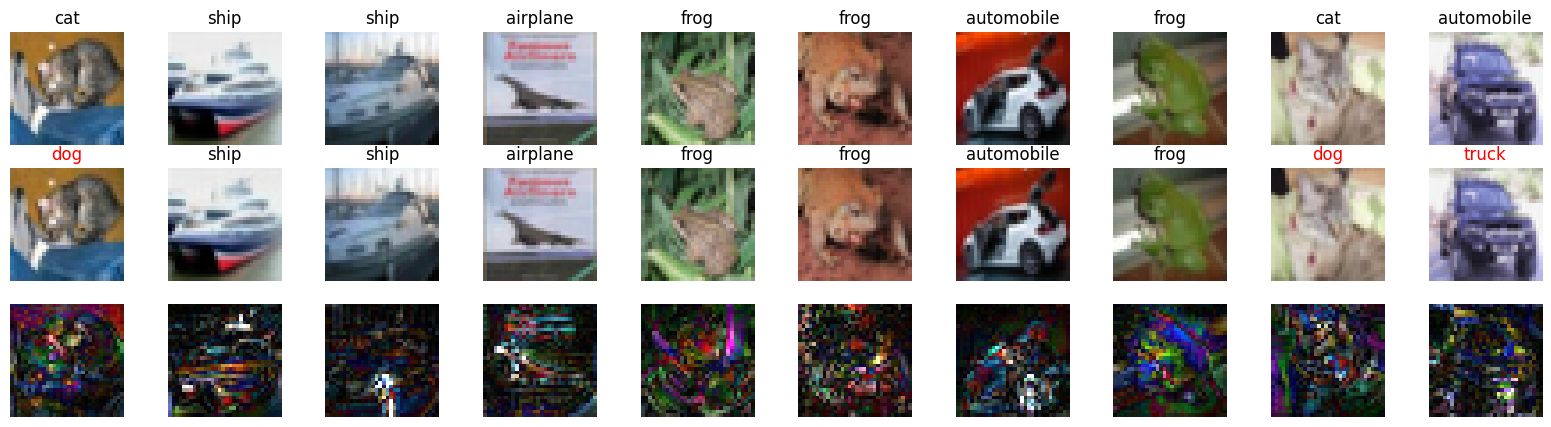

In [15]:
# Repeat for robust model
x_adv, loss_adv = solver(
    data=x.to(device),
    target=y.to(device),
    model=model_robust.to(device)
)

# Compute predictions for adversarial samples
x_adv = x_adv.clamp_(0, 1)
logits_adv = model_robust(x_adv)
y_adv = torch.argmax(logits_adv, axis=1)

# Plot original and adversarial samples
plot_images(x, y, class_names, x_adv, y_adv)

In [16]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns

def generate_confusion_matrix(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g")
    ax.set_xlabel("Predicted", fontsize=20)
    ax.xaxis.set_label_position("bottom")
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel("True", fontsize=20)
    plt.yticks(rotation=0)

    plt.title("Refined Confusion Matrix", fontsize=20)

    plt.show()

    F1_score = f1_score(actual_labels, predicted_labels, average='macro')

    print(f'f1_score: {F1_score}')

Standard Model Performance

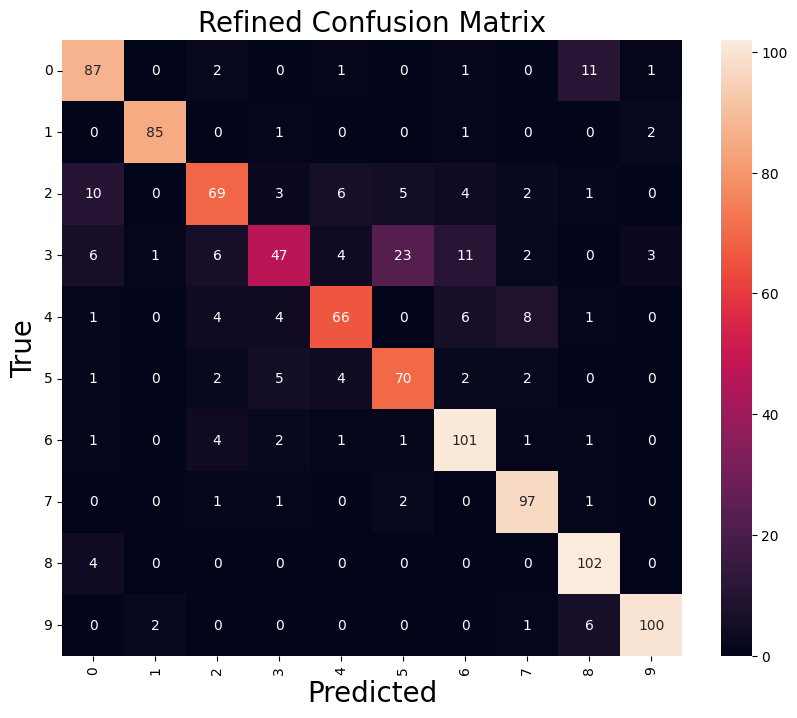

f1_score: 0.8165893291010029


In [20]:
num_batches = 100  # Number of batches to process

# Containers for collected data

collected_x, collected_y, actual_y = [], [], []

# Process the specified number of batches
for batch_idx, (x, y) in enumerate(dataloader):
    if batch_idx >= num_batches:
        break

    actual_y.append(y)
    # Compute predictions for adversarial samples using the standard model
    logits = model_robust(x.to(device))
    y = torch.argmax(logits, dim=1)

    # Store results
    collected_x.append(x)
    collected_y.append(y)


actual_labels_flat = torch.cat(actual_y).cpu().numpy()
predicted_labels_flat = torch.cat(collected_y).cpu().numpy()

generate_confusion_matrix(actual_labels_flat, predicted_labels_flat)

One pixel attack on standard model

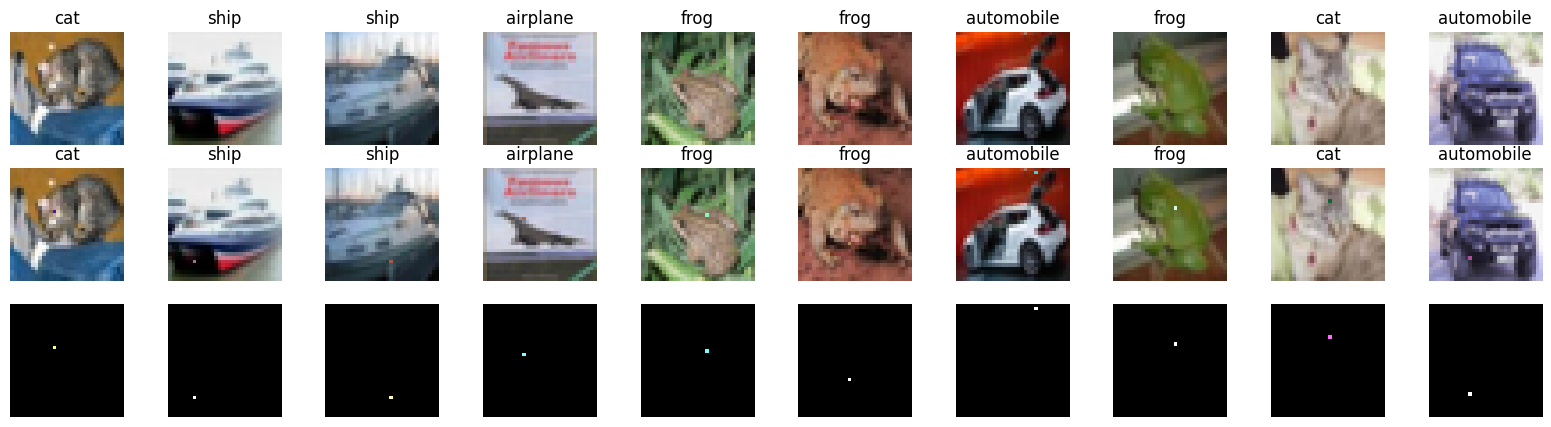

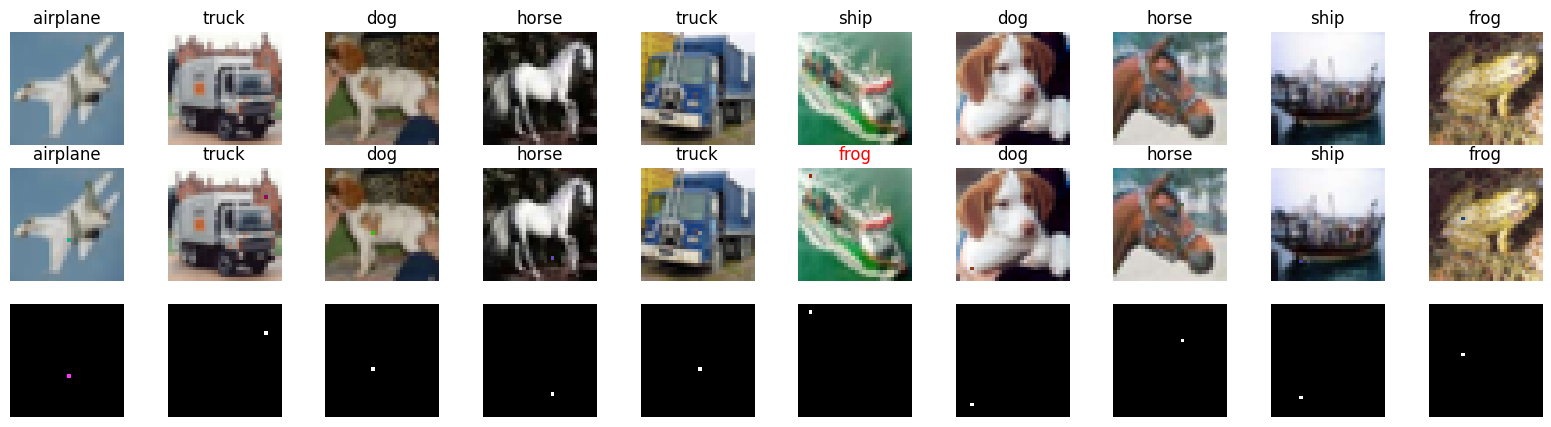

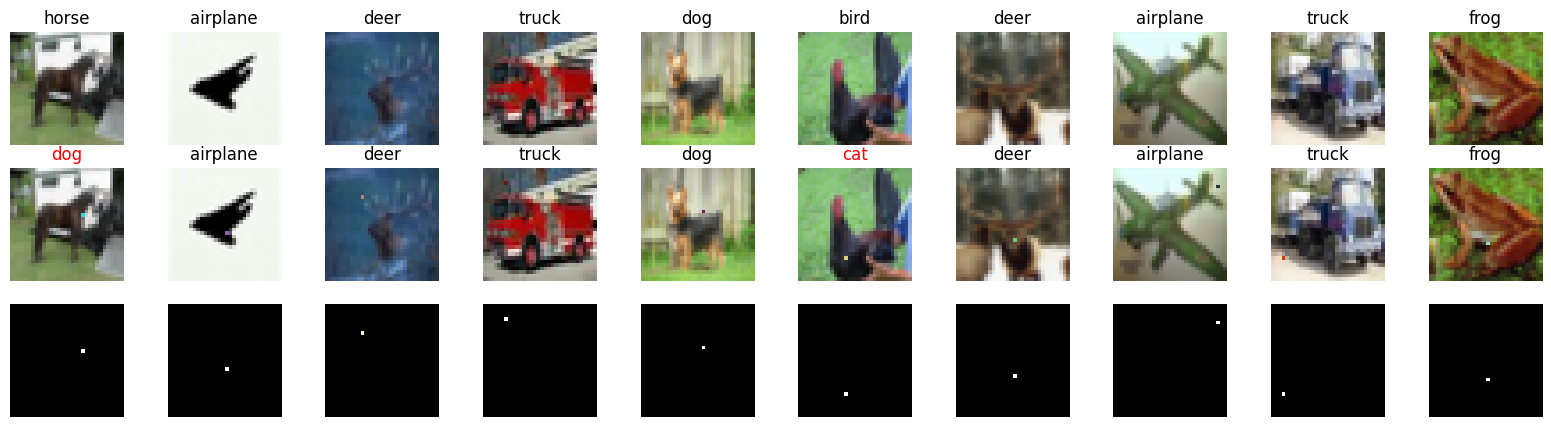

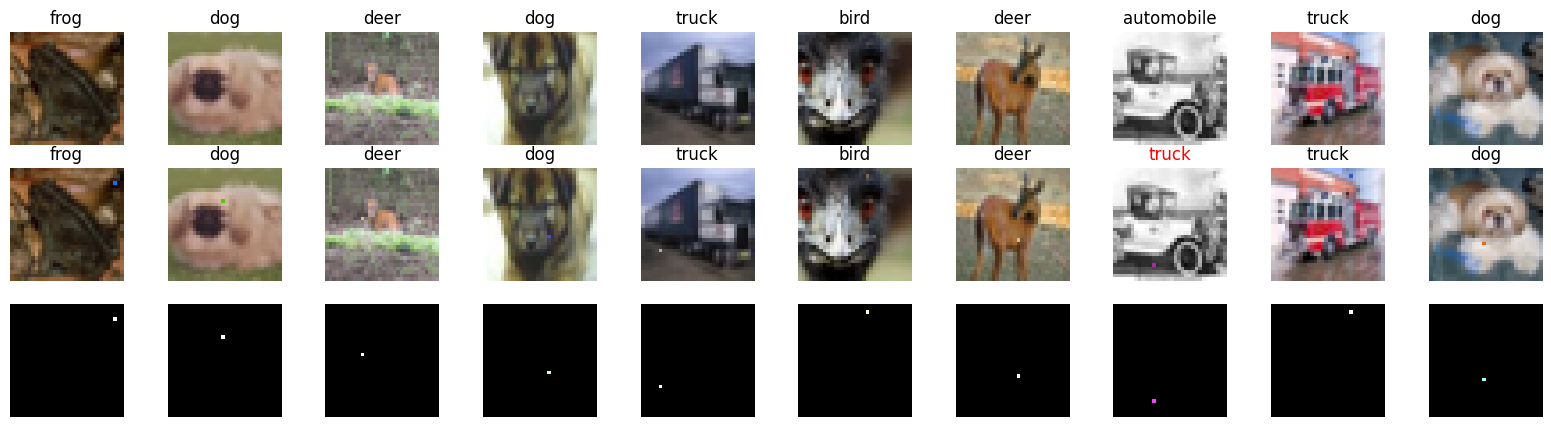

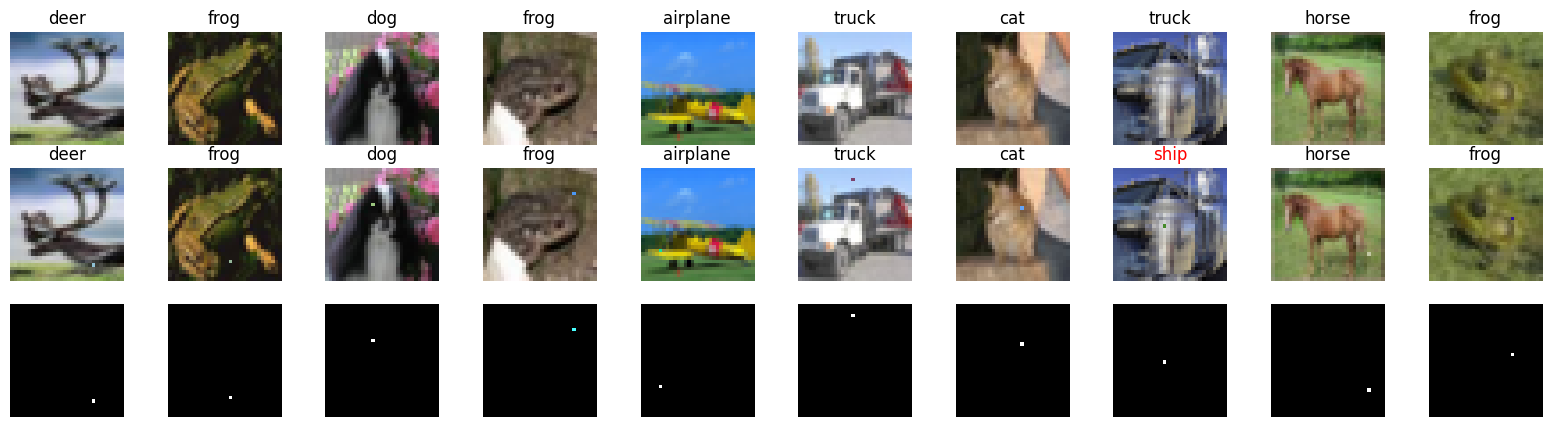

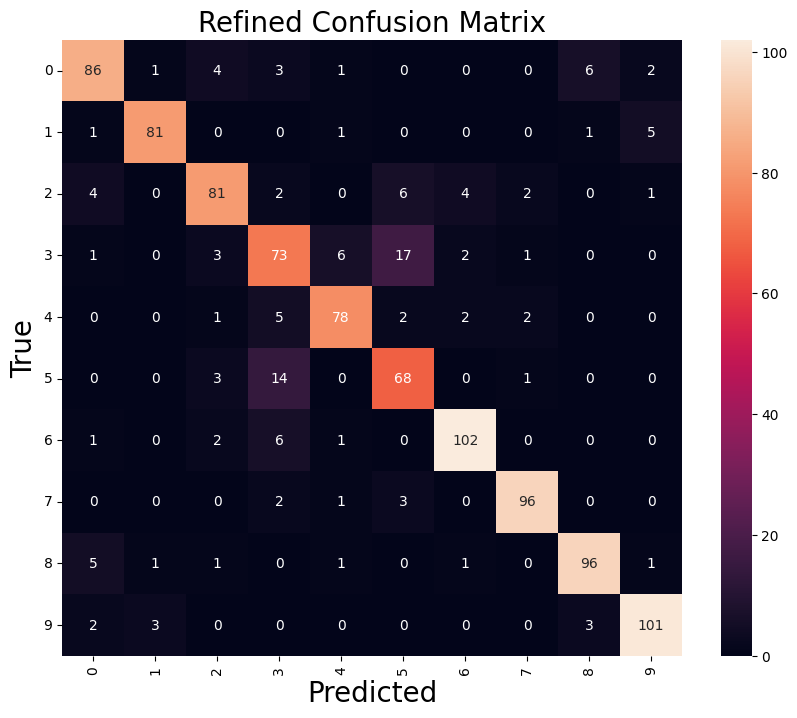

f1_score: 0.8608467844390194


In [18]:
num_batches = 100  # Number of batches to process

# Initialize the attack
one_pixel_attack = torchattacks.OnePixel(model_standard.to(device), pixels=1, steps=10, popsize=10, inf_batch=128)

# Containers for collected data
collected_x, collected_y, collected_x_adv, collected_y_adv = [], [], [], []

# Process the specified number of batches
for batch_idx, (x, y) in enumerate(dataloader):
    if batch_idx >= num_batches:
        break

    # Apply the one pixel attack to generate adversarial examples
    x_adv = one_pixel_attack(x.to(device), y.to(device))

    # Compute predictions for adversarial samples using the standard model
    logits_adv = model_standard(x_adv)
    y_adv = torch.argmax(logits_adv, dim=1)

    # Store results
    collected_x.append(x)
    collected_y.append(y)
    collected_x_adv.append(x_adv.detach().cpu().clamp(0, 1))  # Move to CPU and clamp
    collected_y_adv.append(y_adv.cpu())

    if batch_idx < 5:
        plot_images(x, y, class_names, x_adv, y_adv)

actual_labels_flat = torch.cat(collected_y).cpu().numpy()
predicted_labels_flat = torch.cat(collected_y_adv).cpu().numpy()

generate_confusion_matrix(actual_labels_flat, predicted_labels_flat)

One Pixel Attack on Robust model

KeyboardInterrupt: 

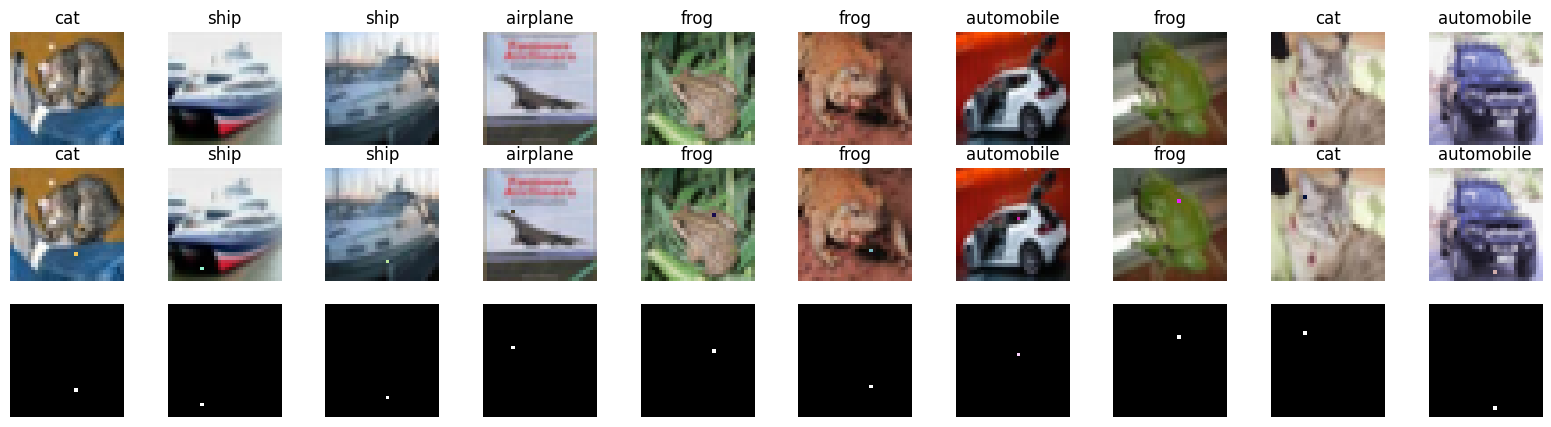

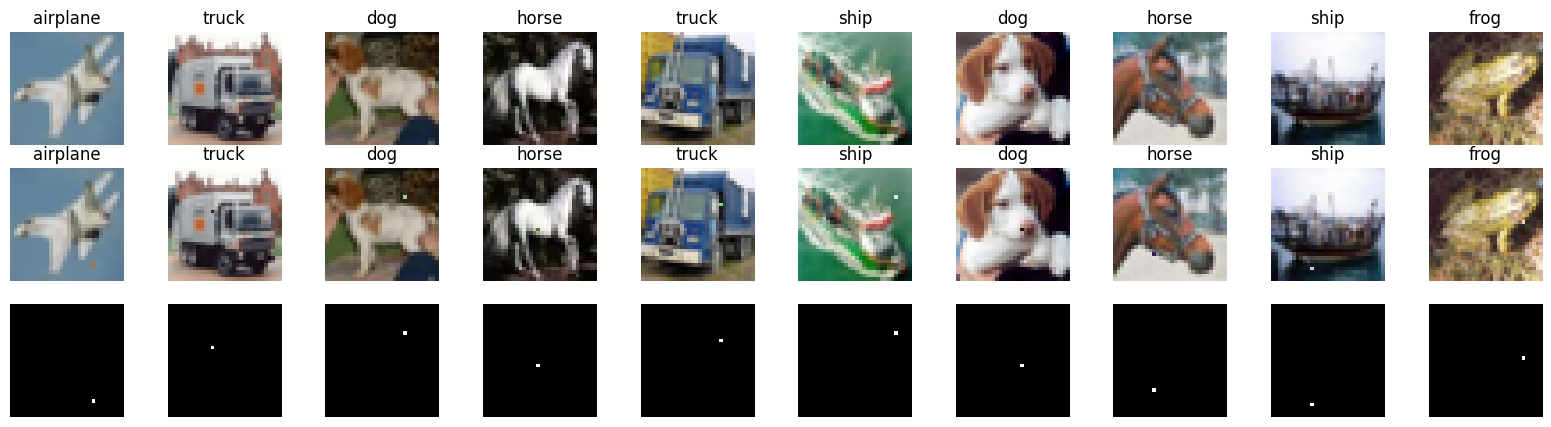

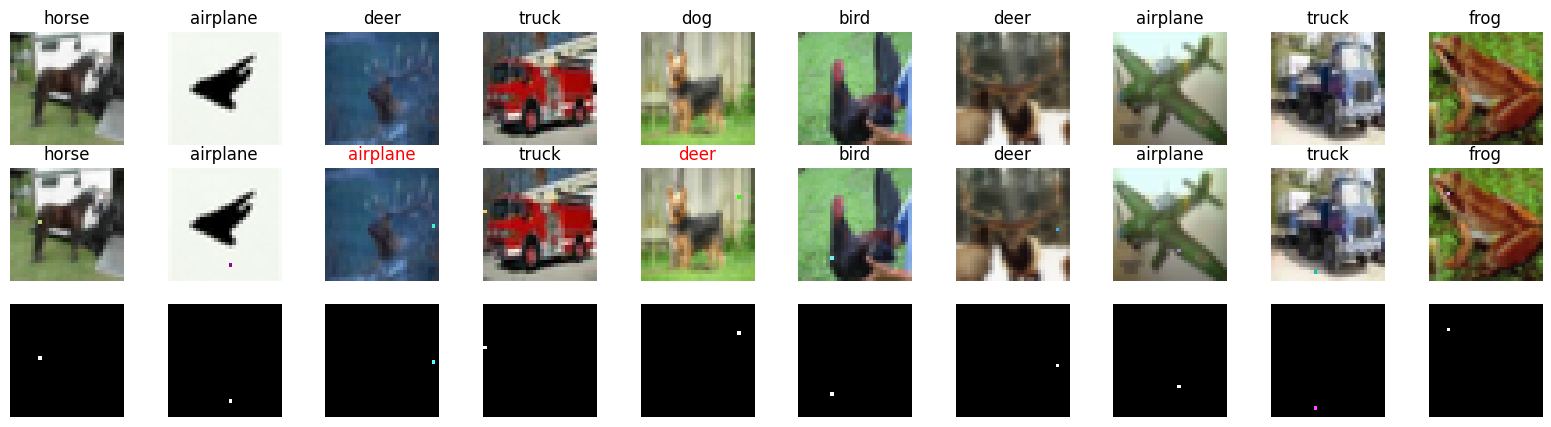

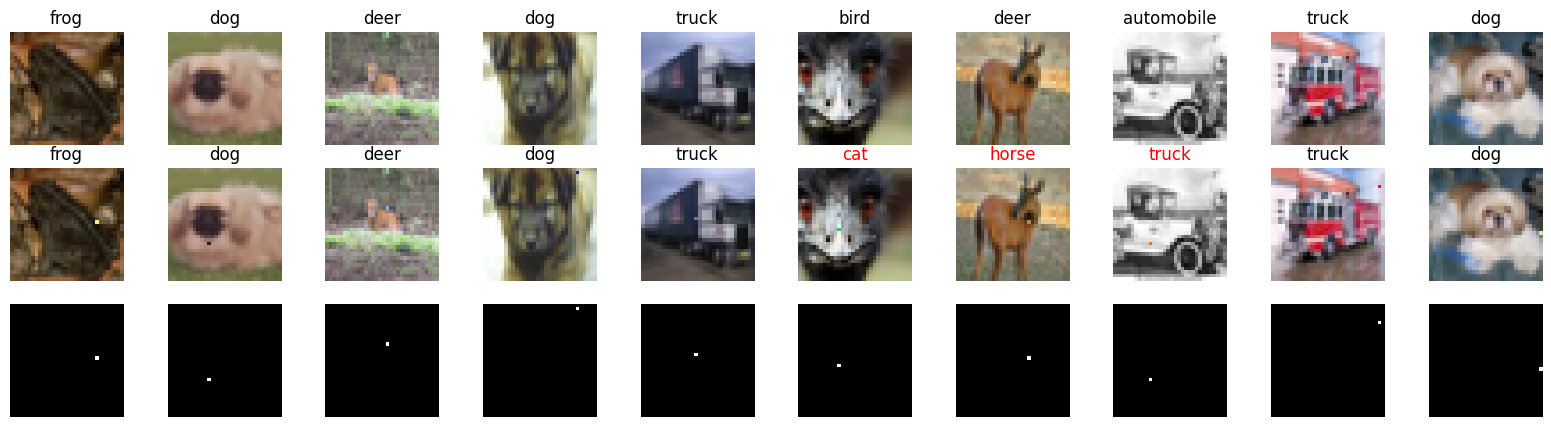

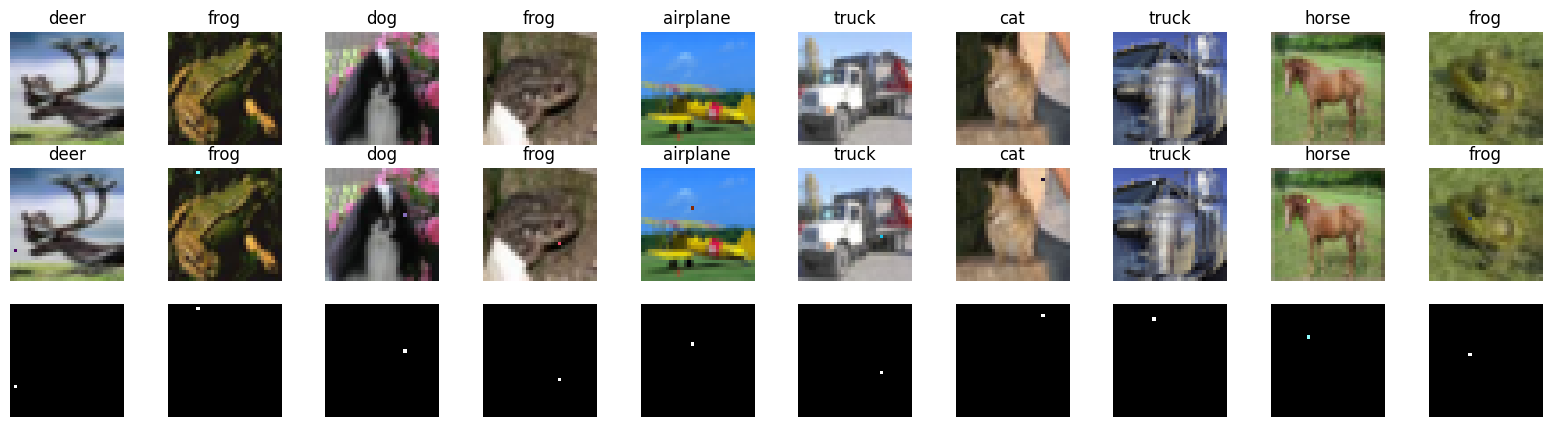

In [19]:
num_batches = 100  # Number of batches to process

# Initialize the attack
one_pixel_attack = torchattacks.OnePixel(model_robust.to(device), pixels=1, steps=10, popsize=10, inf_batch=128)

# Containers for collected data
collected_x, collected_y, collected_x_adv, collected_y_adv = [], [], [], []

# Process the specified number of batches
for batch_idx, (x, y) in enumerate(dataloader):
    if batch_idx >= num_batches:
        break

    # Apply the one pixel attack to generate adversarial examples
    x_adv = one_pixel_attack(x.to(device), y.to(device))

    # Compute predictions for adversarial samples using the standard model
    logits_adv = model_robust(x_adv)
    y_adv = torch.argmax(logits_adv, dim=1)

    # Store results
    collected_x.append(x)
    collected_y.append(y)
    collected_x_adv.append(x_adv.detach().cpu().clamp(0, 1))  # Move to CPU and clamp
    collected_y_adv.append(y_adv.cpu())

    if batch_idx < 5:
        plot_images(x, y, class_names, x_adv, y_adv)

actual_labels_flat = torch.cat(collected_y).cpu().numpy()
predicted_labels_flat = torch.cat(collected_y_adv).cpu().numpy()

generate_confusion_matrix(actual_labels_flat, predicted_labels_flat)